### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os
import pprint as pp
from PIL import Image
from datasets import Dataset
from torch.utils.data import DataLoader, Dataset
import cv2
from tqdm import tqdm
from utils import *
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau, OneCycleLR
import logging
from tqdm import tqdm
from torchmetrics import StructuralSimilarityIndexMeasure

# create the directories where the data is stored
if not os.path.exists("training_data"):
    os.makedirs("training_data")
if not os.path.exists("test_data"):
    os.makedirs("test_data")
if not os.path.exists("submission_files"):
    os.makedirs("submission_files")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cuda')

### Data

In [3]:
folder_path = './training_data/'
seis_files = []
noise_files = []
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.lower().endswith('.npy') and '_RFC_' in file:
            full_path = os.path.join(root, file)
            seis_files.append(full_path)
        elif file.lower().endswith('.npy') and 'seismic_w_noise' in file:
            full_path = os.path.join(root, file)
            noise_files.append(full_path)

In [4]:
folder_path = './training_data_processed/'
seis_files2 = []
noise_files2 = []
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.lower().endswith('.npy') and 'seismic' in file:
            full_path = os.path.join(root, file)
            seis_files2.append(full_path)
        elif file.lower().endswith('.npy') and 'noise' in file:
            full_path = os.path.join(root, file)
            noise_files2.append(full_path)

In [5]:
seismic = np.load(seis_files2[3], allow_pickle=True, mmap_mode="r+")
print(f"Seismic data shape: {seismic.shape}")
noise = np.load(noise_files2[3], allow_pickle=True, mmap_mode="r+")
print(f"Noisy data shape: {noise.shape}")

Seismic data shape: (1259, 300)
Noisy data shape: (1259, 300)


In [6]:
class TrainImageDataset(Dataset):
    def __init__(self, seis_files, noise_files, istest=False):
        """
        Args:
            seis_files (str): Directory with all the clean data.
            noise_files (str): Directory with all the noisy data.
            transform (callable, optional): A function/transform to apply to the images.
            use_magnitude_phase (bool, optional): Whether to use magnitude and phase instead of real and imaginary parts.
        """
        self.seis_files = seis_files
        self.noise_files = noise_files
        self.istest = istest
        
    def __len__(self):
        return len(self.seis_files)

    def __getitem__(self, idx):
        
        seis2d = np.load(self.seis_files[idx], allow_pickle=True, mmap_mode="r+")
        noise2d = np.load(self.noise_files[idx], allow_pickle=True, mmap_mode="r+")
        
        if not self.istest:
            if np.random.rand() > 0.5:
                seis2d = np.fliplr(seis2d)
                noise2d = np.fliplr(noise2d)        
        
        seis2d = cv2.resize(seis2d, (320, 1280))
        noise2d = cv2.resize(noise2d, (320, 1280))
        
        seis_fft_tensor = torch.tensor(seis2d, dtype=torch.float32).unsqueeze(0)

        noise_fft_tensor = torch.tensor(noise2d, dtype=torch.float32).unsqueeze(0)
        return noise_fft_tensor, seis_fft_tensor

In [7]:
class TestImageDataset(Dataset):
    def __init__(self, seis_files, noise_files, istest=False):
        """
        Args:
            seis_files (str): Directory with all the clean data.
            noise_files (str): Directory with all the noisy data.
            transform (callable, optional): A function/transform to apply to the images.
            use_magnitude_phase (bool, optional): Whether to use magnitude and phase instead of real and imaginary parts.
        """
        self.seis_files = seis_files
        self.noise_files = noise_files
        self.istest = istest


    def __len__(self):
        return len(self.seis_files)*300

    def __getitem__(self, idx):

        i_file = idx // 300
        i_slice = idx % 300
        seismic = np.load(self.seis_files[i_file], allow_pickle=True, mmap_mode="r+")
        noise = np.load(self.noise_files[i_file], allow_pickle=True, mmap_mode="r+")
        if self.istest:
            seis2d = seismic[:,i_slice,:].copy()
            noise2d = noise[:,i_slice,:].copy()
        else:
            if np.random.rand() > 0.5:
                seis2d = seismic[:,i_slice,:].copy()
                noise2d = noise[:,i_slice,:].copy()
            else:
                seis2d = seismic[:,:,i_slice].copy()
                noise2d = noise[:,:,i_slice].copy()
                
            if np.random.rand() > 0.5:
                seis2d = np.fliplr(seis2d)
                noise2d = np.fliplr(noise2d)           
            
        seis_min = np.min(seis2d)
        seis_max = np.max(seis2d)
        seis2d = (seis2d - seis_min) / (seis_max - seis_min)
        mean_seis = np.mean(seis2d)
        seis2d = seis2d - mean_seis# + 0.5
        
        noise_min = np.min(noise2d)
        noise_max = np.max(noise2d)
        noise2d = (noise2d - noise_min) / (noise_max - noise_min)
        mean_noise = np.mean(noise2d)
        noise2d = noise2d - mean_noise# + 0.5
        
        scale = np.max(seis2d[:50,:])/np.max(noise2d[:50,:])
        #print(scale)
        seis2d=seis2d/scale
        
        seis2d = seis2d + 0.5
        noise2d = noise2d + 0.5
        
        seis2d = cv2.resize(seis2d, (320, 1280))
        noise2d = cv2.resize(noise2d, (320, 1280))
        
        seis_fft_tensor = torch.tensor(seis2d, dtype=torch.float32).unsqueeze(0)

        noise_fft_tensor = torch.tensor(noise2d, dtype=torch.float32).unsqueeze(0)
        return noise_fft_tensor, seis_fft_tensor

In [8]:
train_dataset = TrainImageDataset(seis_files2[:-70*15-1], noise_files2[:-70*15-1])
val_dataset = TrainImageDataset(seis_files2[-70*15:], noise_files2[-70*15:], istest=True)

In [9]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)

In [10]:
test_data, test_label = val_dataset[-1]

In [11]:
test_data.max()

tensor(0.9699)

In [12]:
test_data.min()

tensor(0.1056)

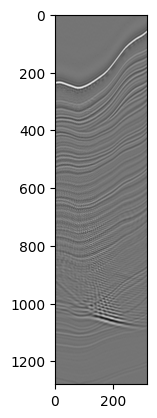

In [13]:
plt.imshow(test_data[0], cmap='gray')

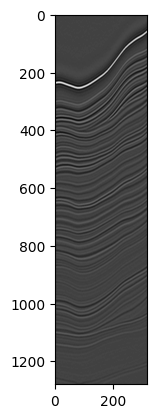

In [14]:
plt.imshow(test_label[0], cmap='gray')

In [15]:
test_label.max()

tensor(0.9626)

In [16]:
test_label.min()

tensor(0.3374)

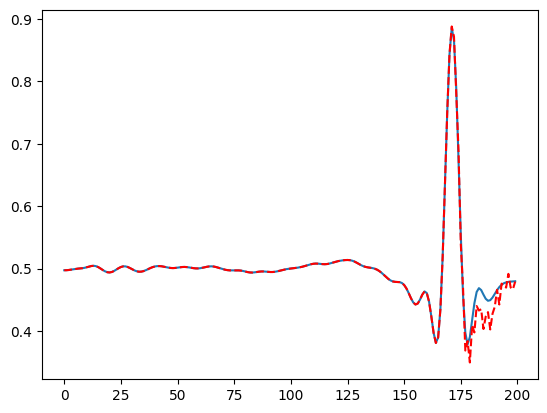

In [17]:
plt.plot(test_label[0,:200,200])
plt.plot(test_data[0,:200,200], '--r')

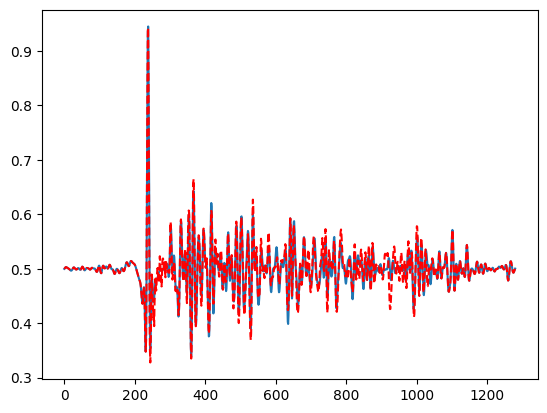

In [18]:
plt.plot(test_label[0,:,0])
plt.plot(test_data[0,:,0], '--r')

In [19]:
test_data, test_label = val_dataset[-1]

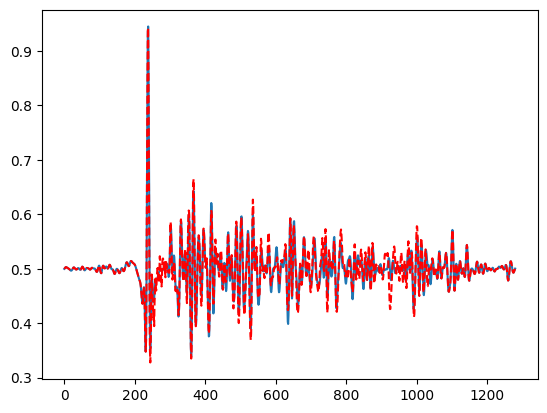

In [20]:
plt.plot(test_label[0,:,0])
plt.plot(test_data[0,:,0], '--r')

### Model Architecture

VIT Bottleneck

In [21]:
from vit_pytorch import ViT

v = ViT(
    num_classes = 1,
    image_size = (1280, 320), 
    patch_size = (32, 8), 
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1,
    channels = 1
)
v.mlp_head = nn.Identity()
img = torch.randn(1, 1, 1280, 320) 

preds = v(img) # (1, 1000)

Unet

In [22]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

from vit_pytorch import ViT
        
class UNet(nn.Module):
    def __init__(self, n_channels, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.bilinear = bilinear
        factor = 2 if bilinear else 1
        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128 // factor)
        
        #self.down4 = Down(512, 1024 // factor)
        
        #self.vit = ViT(image_size = 20,patch_size = 10,dim = 2048, depth = 2, heads = 16,mlp_dim = 12,channels = 512) #dim%head=0
        self.vit = ViT(num_classes = 1,
                        image_size = (160, 40),  # image size is a tuple of (height, width)
                        patch_size = (10, 10),    # patch size is a tuple of (height, width)
                        #num_classes = 1,
                        dim = 2048,
                        depth = 6,
                        heads = 16,
                        mlp_dim = 2048,
                        dropout = 0.1,
                        emb_dropout = 0.1,
                        channels = 64
                       )
        self.vit.mlp_head = nn.Identity()
        self.vit_conv = nn.Conv2d(32,256,kernel_size = 1,padding = 0) #to increase the number of channels
        self.vit_linear = nn.Linear(64,6400)
        
        #self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        #x5 = self.down4(x4)
        
        #applying Vision Transformer
        #print(x4.shape)
        x6 = self.vit(x4) #[4,2048]
        #print(x6.shape)
        x6 = torch.reshape(x6,(-1,32,8,8)) #[4,32,8,8]
        #print(x6.shape)
        x7 = self.vit_conv(x6) #[4,512,8,8]
        #print(x7.shape)
        x8 = self.vit_linear(torch.reshape(x7,(-1,256,64))) #[4,512,1024]
        #print("last", x8.shape)
        x9 = torch.reshape(x8,(-1,64,320,80))
        #print(x9.shape, x3.shape)
        #x = self.up1(x9, x4)
        x = self.up2(x9, x3)
        #print(x.shape)
        x = self.up3(x, x2)
        #print(x.shape)
        x = self.up4(x, x1)
        #print(x.shape)
        logits = self.outc(x)
        return logits

if __name__ == '__main__':
    model = UNet(n_channels=1, bilinear=True).to(device)

    noisy_image = torch.rand(1, 1, 1280, 320).to(device)  # Example noisy grayscale image
    denoised_image = model(noisy_image)
    print("Denoised image shape:", denoised_image.shape)  # Should match (1, 1, 1280, 320)

Denoised image shape: torch.Size([1, 1, 1280, 320])


In [23]:
summary(model, input_size=(1, 1280, 320))

Layer (type:depth-idx)                   Param #
├─DoubleConv: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  160
|    |    └─BatchNorm2d: 3-2             32
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  2,320
|    |    └─BatchNorm2d: 3-5             32
|    |    └─ReLU: 3-6                    --
├─Down: 1-2                              --
|    └─Sequential: 2-2                   --
|    |    └─MaxPool2d: 3-7               --
|    |    └─DoubleConv: 3-8              14,016
├─Down: 1-3                              --
|    └─Sequential: 2-3                   --
|    |    └─MaxPool2d: 3-9               --
|    |    └─DoubleConv: 3-10             55,680
├─Down: 1-4                              --
|    └─Sequential: 2-4                   --
|    |    └─MaxPool2d: 3-11              --
|    |    └─DoubleConv: 3-12             74,112
├─ViT: 1-5                               --
|    └─Sequ

Layer (type:depth-idx)                   Param #
├─DoubleConv: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  160
|    |    └─BatchNorm2d: 3-2             32
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  2,320
|    |    └─BatchNorm2d: 3-5             32
|    |    └─ReLU: 3-6                    --
├─Down: 1-2                              --
|    └─Sequential: 2-2                   --
|    |    └─MaxPool2d: 3-7               --
|    |    └─DoubleConv: 3-8              14,016
├─Down: 1-3                              --
|    └─Sequential: 2-3                   --
|    |    └─MaxPool2d: 3-9               --
|    |    └─DoubleConv: 3-10             55,680
├─Down: 1-4                              --
|    └─Sequential: 2-4                   --
|    |    └─MaxPool2d: 3-11              --
|    |    └─DoubleConv: 3-12             74,112
├─ViT: 1-5                               --
|    └─Sequ

In [24]:
criterion1 = nn.MSELoss() #reduction='sum'
criterion2 = nn.L1Loss()

In [25]:
logging.basicConfig(filename='training_log_vitunet.txt', level=logging.INFO, format='%(asctime)s - %(message)s')

In [26]:
num_epochs = 30

In [27]:
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=0.001
)

In [28]:
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6) 

In [29]:
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)  # SSIM expects normalized data in [0, 1]

C:\Users\Leo\miniconda3\lib\site-packages\torchmetrics\utilities\prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


In [30]:
alpha = 0.5
# Training and evaluation loop
best_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_ssim = 0.0

    # Training loop with tqdm
    train_loader_tqdm = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
    for batch_idx, (data, label) in enumerate(train_loader_tqdm):
        optimizer.zero_grad()
        
        data = data.to(device)
        label = label.to(device)
        
        outputs = model(data)

        loss1 = criterion1(outputs, label)
        loss2 = 1 - ssim_metric(outputs, label)
        scaleloss = loss2/loss1
        loss = loss1*scaleloss*alpha + loss2*(1-alpha)
        
        # Accumulate loss and SSIM for the training batch
        running_loss += loss.item()
        running_ssim += 1 - loss2.item()

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()
        train_loader_tqdm.set_postfix({"Loss": running_loss / (batch_idx + 1), "SSIM": running_ssim / (batch_idx + 1)})

    # Calculate average loss and SSIM for the training set
    avg_train_loss = running_loss / len(train_dataloader)
    avg_train_ssim = running_ssim / len(train_dataloader)

    # Log the training loss and SSIM
    logging.info(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.5f}, Train SSIM: {avg_train_ssim:.5f}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.5f}, Train SSIM: {avg_train_ssim:.5f}')

    # Evaluation on test set with tqdm
    model.eval()
    test_loss = 0.0
    test_ssim = 0.0
    with torch.no_grad():
        test_loader_tqdm = tqdm(test_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Testing")
        for batch_idx, (data, label) in enumerate(test_loader_tqdm):
            data = data.to(device)
            label = label.to(device)
            outputs = model(data)
            loss1 = criterion1(outputs, label)
            loss2 = 1 - ssim_metric(outputs, label)
            scaleloss = loss2/loss1
            loss = loss1*scaleloss*alpha + loss2*(1-alpha)
            
            test_loss += loss.item()
            test_ssim += 1-(loss2.item())

            # Update tqdm description with current loss and SSIM
            test_loader_tqdm.set_postfix({"Loss": test_loss / (batch_idx + 1), "SSIM": test_ssim / (batch_idx + 1)})

    # Calculate average loss and SSIM for the test set
    avg_test_loss = test_loss / len(test_dataloader)
    avg_test_ssim = test_ssim / len(test_dataloader)


    
    # Log the test loss and SSIM
    logging.info(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {avg_test_loss:.5f}, Test SSIM: {avg_test_ssim:.5f}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {avg_test_loss:.5f}, Test SSIM: {avg_test_ssim:.5f}')
    # Check if the current test loss is the best we've seen so far
    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        torch.save(model.state_dict(), 'vitunet_best.pth')
        logging.info(f'Saved model with loss {best_loss:.5f}')
        print(f'Saved model with loss {best_loss:.5f}')
        
    scheduler.step()
    #scheduler.step(metrics=avg_test_ssim)
    print(f"Epoch {epoch + 1}: Learning Rate = {scheduler.get_last_lr()}")
torch.save(model.state_dict(), 'vitunet_lastep.pth')

Epoch 1/30 - Training:   0%|                                                                  | 0/3833 [00:00<?, ?it/s]C:\Users\Leo\miniconda3\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1/30 - Training:  49%|██████████████▊               | 1888/3833 [10:23<10:41,  3.03it/s, Loss=0.0333, SSIM=0.967]


KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load('vitunet_best.pth'))

In [ ]:
test_dataset = TestImageDataset(seis_files[-3:], noise_files[-3:], istest=True)

In [ ]:
from skimage.metrics import structural_similarity as sk_ssim

In [ ]:
with torch.no_grad():
    test_loader_tqdm = tqdm(test_dataloader, desc=f"Testing")
    for (data, label) in test_loader_tqdm:
        data = data.to(device)
        label = label.to(device)
        outputs = model(data)
        #loss = criterion(outputs, label)
        break

In [ ]:
oreal_part = outputs[0, 0, :, :].cpu()
lreal_part = label[0, 0, :, :].cpu()
dreal_part = data[0, 0, :, :].cpu()

In [ ]:
oreal_part = outputs[0, 0, :, :].cpu().numpy()
lreal_part = label[0, 0, :, :].cpu().numpy()
dreal_part = data[0, 0, :, :].cpu() .numpy()

In [ ]:
sk_ssim(oreal_part, lreal_part, data_range=1)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 12))

# Original Data
ax[0].imshow(oreal_part )
ax[0].set_title('output Data')
ax[0].axis('off')

# Magnitude Spectrum
ax[1].imshow(lreal_part)
#ax[1].imshow(np.log(magnitude_spectrum + 1))
ax[1].set_title('Label')
ax[1].axis('off')

ax[2].imshow(dreal_part)
#ax[1].imshow(np.log(magnitude_spectrum + 1))
ax[2].set_title('data')
ax[2].axis('off')

plt.show()

In [ ]:
with torch.no_grad():
    test_loader_tqdm = tqdm(test_dataloader, desc=f"Epoch Testing")
    for (data, label) in test_loader_tqdm:
        data = data.to(device)
        label = label.to(device)
        outputs = model(data)
        #loss = criterion(outputs, label)
        break

In [ ]:
oreal_part = outputs[0, 0, :, :].cpu().numpy()
lreal_part = label[0, 0, :, :].cpu().numpy()
dreal_part = data[0, 0, :, :].cpu() .numpy()

In [ ]:
sk_ssim(oreal_part, lreal_part, data_range=1)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 12))

# Original Data
ax[0].imshow(oreal_part )
ax[0].set_title('output Data')
ax[0].axis('off')

# Magnitude Spectrum
ax[1].imshow(lreal_part)
#ax[1].imshow(np.log(magnitude_spectrum + 1))
ax[1].set_title('Label')
ax[1].axis('off')

ax[2].imshow(dreal_part)
#ax[1].imshow(np.log(magnitude_spectrum + 1))
ax[2].set_title('data')
ax[2].axis('off')

plt.show()

In [ ]:
plt.plot(oreal_part[:800,0])
plt.plot(lreal_part[:800,0],'--r')